In [6]:
from rule_prunning import *

In [16]:
test_rules_hospital="""t1&t2&EQ(t1.Condition,t2.Condition)&EQ(t1.MeasureName,t2.MeasureName)&IQ(t1.HospitalType,t2.HospitalType)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ZipCode,t2.ZipCode)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.PhoneNumber,t2.PhoneNumber)
t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.MeasureName,t2.MeasureName)
t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Stateavg,t2.Stateavg)
t1&t2&EQ(t1.ProviderNumber,t2.ProviderNumber)&IQ(t1.HospitalName,t2.HospitalName)
t1&t2&EQ(t1.CountyName,t2.CountyName)&IQ(t1.ZipCode,t2.ZipCode)
t1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Condition,t2.Condition)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.Address1,t2.Address1)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.HospitalOwner,t2.HospitalOwner)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ProviderNumber,t2.ProviderNumber)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&EQ(t1.PhoneNumber,t2.PhoneNumber)&EQ(t1.HospitalOwner,t2.HospitalOwner)&IQ(t1.State,t2.State)
t1&t2&EQ(t1.City,t2.City)&IQ(t1.CountyName,t2.CountyName)
t1&t2&EQ(t1.ZipCode,t2.ZipCode)&IQ(t1.EmergencyService,t2.EmergencyService)
t1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.City,t2.City)
t1&t2&EQ(t1.MeasureName,t2.MeasureName)&IQ(t1.MeasureCode,t2.MeasureCode)
t1&t2&EQ(t1.ZipCode,t2.ZipCode)&IQ(t1.CountyName,t2.CountyName)"""
test_rules = test_rules_hospital.split('\n')
print(test_rules)
c=Complaint(complain_type='DC', complaint_instance='Condition')
rp=RulePruner()
graph, res = rp.prune_and_return(complaint=c,rules=test_rules)
print(f"before pruning: we have {len(test_rules)} rules ")
print(f"after pruning: we have {len(res)} rules ")

['t1&t2&EQ(t1.Condition,t2.Condition)&EQ(t1.MeasureName,t2.MeasureName)&IQ(t1.HospitalType,t2.HospitalType)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ZipCode,t2.ZipCode)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.PhoneNumber,t2.PhoneNumber)', 't1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.MeasureName,t2.MeasureName)', 't1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Stateavg,t2.Stateavg)', 't1&t2&EQ(t1.ProviderNumber,t2.ProviderNumber)&IQ(t1.HospitalName,t2.HospitalName)', 't1&t2&EQ(t1.CountyName,t2.CountyName)&IQ(t1.ZipCode,t2.ZipCode)', 't1&t2&EQ(t1.MeasureCode,t2.MeasureCode)&IQ(t1.Condition,t2.Condition)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.Address1,t2.Address1)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.HospitalOwner,t2.HospitalOwner)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&IQ(t1.ProviderNumber,t2.ProviderNumber)', 't1&t2&EQ(t1.HospitalName,t2.HospitalName)&EQ(t1.PhoneNumber,t2.PhoneNumber)&EQ(t1.HospitalOwner,t2.HospitalOwner)&IQ(t1.State

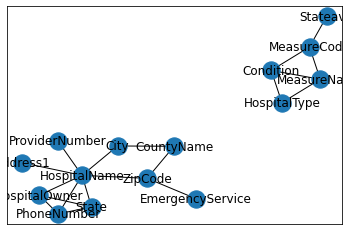

In [17]:
pos = nx.nx_pydot.graphviz_layout(graph)
nx.draw_networkx(graph, pos)

In [9]:
test_rules = """t1&t2&IQ(t1.Sex,t2.Sex)&EQ(t1.Occupation,t2.Occupation)&IQ(t1.Country,t2.Country)
t1&t2&EQ(t1.Relationship,t2.Relationship)&EQ(t1.Education,t2.Education)&IQ(t1.Maritalstatus,t2.Maritalstatus)"""
test_rules = test_rules.split('\n')
print(test_rules)
c=Complaint(complain_type='DC', complaint_instance='Country')
rp=RulePruner()
dp=DataPruner()
graph, res = rp.prune_and_return(complaint=c,rules=test_rules)
print(f"before pruning: we have {len(test_rules)} rules ")
print(f"after pruning: we have {len(res)} rules ")
conn = psycopg2.connect(dbname="holo", user="holocleanuser", password="abcd1234")
conn.autocommit=True
dp.dc_prune_and_return(db_conn=conn,target_table='adult',pruned_rules=res)

['t1&t2&IQ(t1.Sex,t2.Sex)&EQ(t1.Occupation,t2.Occupation)&IQ(t1.Country,t2.Country)', 't1&t2&EQ(t1.Relationship,t2.Relationship)&EQ(t1.Education,t2.Education)&IQ(t1.Maritalstatus,t2.Maritalstatus)']
set_useful_nodes: {'Sex', 'Occupation', 'Country'}
useless rules: ['t1&t2&EQ(t1.Relationship,t2.Relationship)&EQ(t1.Education,t2.Education)&IQ(t1.Maritalstatus,t2.Maritalstatus)']
before pruning: we have 2 rules 
after pruning: we have 1 rules 
before pruning data: adult has 500 rows
after pruning data: adult_pruned has 323 rows


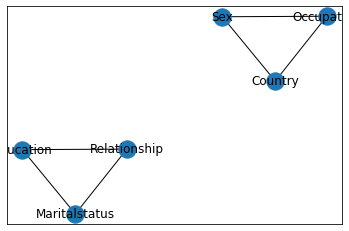

In [10]:
pos = nx.nx_pydot.graphviz_layout(graph)
nx.draw_networkx(graph, pos)